In [167]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import plotly.express as px
import plotly.graph_objects as go
import os
from statistics import mean,stdev,median
from math import log
import seaborn as sns

### =========================================================================================

### FUNCTIONS

### =========================================================================================

In [533]:
def rename_df(df):
    column_rename = {}
    for i in list(df.columns):
        if '210527' in i and '.' not in i:
            if 'PBQC' in i:
                column_rename[i] = 'PBQC_'+str(i.split('_')[-1])
            else:
                if int(i.split('_')[-1]) < 8:
                    column_rename[i] = 'DEN_AdjLiver_Fasted_'+str(i.split('_')[-1])      
                elif int(i.split('_')[-1]) < 15:
                    column_rename[i] = 'DEN_Tumour_Fasted_'+str(i.split('_')[-1]) 
                elif int(i.split('_')[-1]) < 21:
                    column_rename[i] = 'nonDEN_Liver_Fasted_'+str(i.split('_')[-1])
                elif int(i.split('_')[-1]) < 30:
                    column_rename[i] = 'DEN_AdjLiver_Fed_'+str(i.split('_')[-1])
                elif int(i.split('_')[-1]) < 38:
                    column_rename[i] = 'DEN_Tumour_Fed_'+str(i.split('_')[-1])
                elif int(i.split('_')[-1]) <= 42:
                    column_rename[i] = 'nonDEN_Liver_Fed_'+str(i.split('_')[-1])
                else:
                    print(i)
        else:
            pass
    df2 = df.rename(columns=column_rename)
    selectCols = list(column_rename.values())
    selectCols.append('Compound')
    df2 = df2[selectCols]
    return df2

In [406]:
def createSampleAnnotation(df):
    sample_annot = pd.DataFrame()
    group_number = 0
    done = []
    counter = 0
    for row in df.index:
        parts = row.split('_')
        group = str('_'.join(parts[0:-1]))
        sample_annot.at[counter,'Group'] = group
        if group not in done:
            done.append(group)
            group_number += 1
            sample_annot.at[counter,'Group_number'] = group_number
        else:
            sample_annot.at[counter,'Group_number'] = group_number
        counter += 1
    return sample_annot

In [193]:
def removeUninformative(df):
    toDrop = []
    for col in df.columns:
        l = list(set(df_combined[col]))
        if len(l) == 1:
            toDrop.append(col)
    df = df.drop(toDrop,axis=1)
    return df

In [378]:
def medianScaling(df,logScale):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in df_scaled.columns:
        medianMinPA = (df[column].loc[df[column] != 0]).median()
        df_scaled[column] = df_scaled[column]  / medianMinPA
    df_scaled = df_scaled.astype('float')
    if logScale == True:
        for column in df_scaled.columns:
            df_scaled[column] = np.log10(df_scaled[column])
    else:
        df_scaled = df_scaled
    df_scaled.replace(np.inf, 0, inplace=True)
    df_scaled.replace(-np.inf, 0, inplace=True)
    return df_scaled

### =========================================================================================

#### Read in positive and neagtive ion data sheets

In [514]:
df_pos = pd.read_csv('For Frederick/Data/AA210511_A_Pos_Compound measurements.csv',skiprows=2)
df_neg = pd.read_csv('For Frederick/Data/AA210511_A_Neg_Compound measurements.csv',skiprows=2)

#### rename the dataframes to biological names and concatenate

In [522]:
df_pos_parsed = rename_df(df_pos)
df_neg_parsed = rename_df(df_neg)
df_combined = pd.concat([df_pos_parsed,df_neg_parsed])

#### coefficient of variation (cv) cut-off 

In [523]:
df_pos_cv = pd.read_csv('For Frederick/Data/AA210511_A_Pos_Compound measurements_PBQCs.csv',skiprows=2)
df_neg_cv = pd.read_csv('For Frederick/Data/AA210511_A_Neg_Compound measurements_PBQCs.csv',skiprows=2)
cv_d = {**dict(zip(df_pos_cv['Compound'],df_pos_cv['Minimum CV >= 30'])),**dict(zip(df_neg_cv['Compound'],df_pos_cv['Minimum CV >= 30']))}
cv_cutoff = []
for i in cv_d:
    if cv_d[i] == 'x':
        cv_cutoff.append(str(i).strip())

In [524]:
df_combined = df_combined.T
df_combined.columns = df_combined.loc['Compound']
df_combined = df_combined.drop(['Compound'], axis=0)
df_combined = df_combined.drop(cv_cutoff,axis=1)

In [525]:
df_combined = removeUninformative(df_combined)
df_combined = medianScaling(df_combined,logScale=True)
df_combined = removeUninformative(df_combined)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log10



In [526]:
sample_annot = createSampleAnnotation(df_combined)

In [527]:
len(df_combined.columns)

1869

In [528]:
d = []
for index,row in df_combined.iterrows():
    for column in df_combined.columns:
        d.append({'X' : row[column],
                  'Y' : row[column]})
toPlot = pd.DataFrame(d)

In [529]:
fig = px.scatter(toPlot,
                 x = 'X',
                 y = 'Y',
                 template = 'none')
fig.update_layout(autosize=False,height=300,width=500)
fig.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



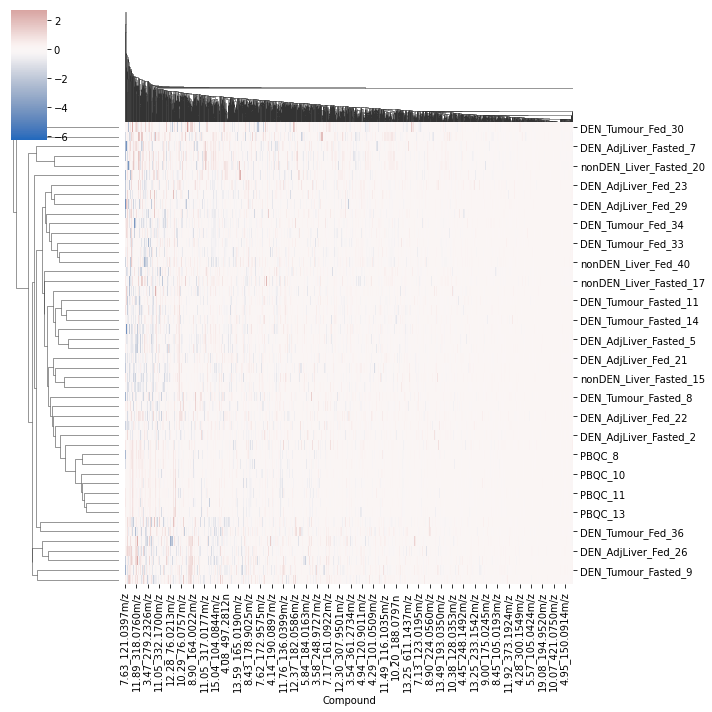

In [530]:
sns.clustermap(df_combined,cmap='vlag',center=0)

#### Create PLS-DA plot using groups as clustering input

In [539]:
plsr = PLSRegression(n_components=3, scale=False)
plsr.fit(df_combined,sample_annot['Group_number'])
principalComponents = plsr.x_scores_
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Component 1', 'Component 2','Component 3'])
finalDf = pd.concat([principalDf, sample_annot[['Group']]], axis = 1)

#### Create PCA plot

In [536]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_combined)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Component 1', 'Component 2'])
finalDf = pd.concat([principalDf, sample_annot[['Group']]], axis = 1)

In [537]:
fig = px.scatter(finalDf, 
                 x = "Component 1", 
                 y = "Component 2",
                 color = 'Group',
                 template = 'none')
fig = fig.update_layout(autosize = False,
                        height = 500,
                        width = 650,
                        font_family="Arial",
                        font_color="black",
                        font_size=12)
fig.update_traces(mode='markers', 
                  marker_line_width=2, 
                  marker_size=14)
#fig.write_image('Figures/PLSDA.pdf')
fig.show()

In [541]:
fig = px.scatter_3d(finalDf, x='Component 1', y='Component 2', z='Component 3',
              color='Group',template='seaborn')
fig.update_layout(autosize=False,
                  height=1000,
                  width=1000)
fig.show()